In [2]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [3]:
using BenchmarkTools;
using CUDA
using Base: @doc
using Revise
using Random: shuffle, randperm

push!(LOAD_PATH, "../../src");
using Pose2D
using Geometry: Segment
using MyUtils
using Raycaster
using SensorDistributions;

[ Info: Precompiling Pose2D [top-level]
[ Info: Precompiling Geometry [top-level]
[ Info: Precompiling Raycaster [top-level]
[ Info: Precompiling SensorDistributions [top-level]


In [99]:
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt: @f_str, format # Python-style f-strings
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using GenDistributionZoo: ProductDistribution

const diagnormal = broadcasted_normal

mvuniform = ProductDistribution(uniform);

## Load Environment

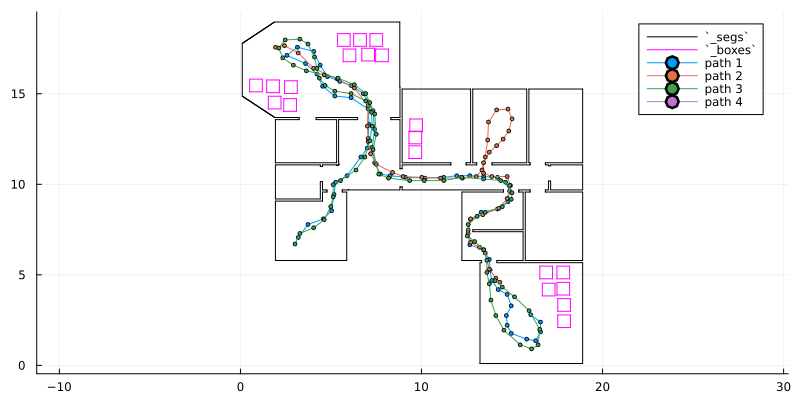

In [5]:
include("../../src/house_expo_utils.jl");

fname = "../data/task_inputs/test_env_2.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=2, c=col[i], label="path $i")
end
mypl

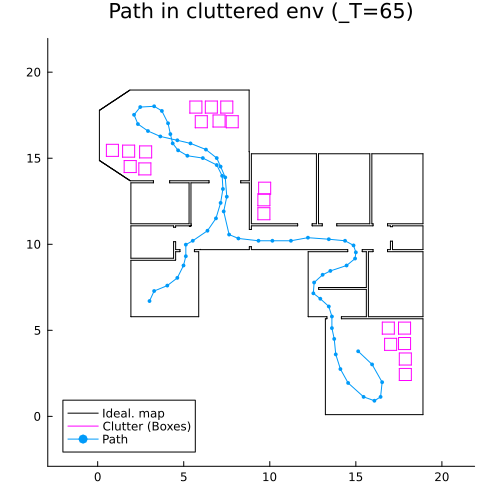

In [6]:
_ps, _us = unpack_path(_paths[3])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

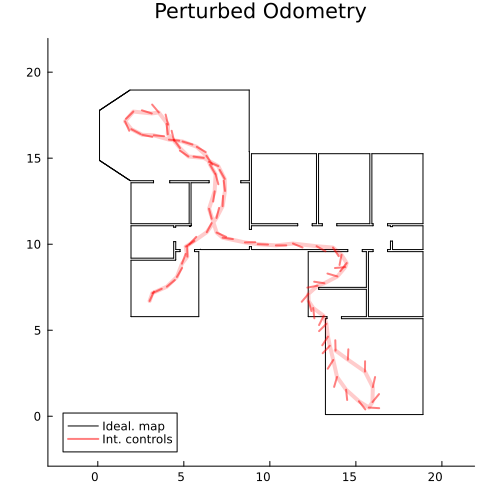

In [7]:
#nbx
x_noise  = 0.1
hd_noise = 5/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps_noisy = [_ps[1]]
for u in us_noisy
    push!(ps_noisy, ps_noisy[end] + u)
end

# -----------------
env_plt = plot(
    size=(500,500), aspect_ratio=:equal, title="Perturbed Odometry", axis=true, grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!([p.x for p in ps_noisy], c=:red, label=nothing, alpha=0.2, linewidth=4)

plot!(ps_noisy[[1]],     c=:red,  r=.6, label="Int. controls", alpha=0.5, linewidth=2)
plot!(ps_noisy[2:end], c=:red,  r=.6,  label=nothing,  alpha=0.5, linewidth=2)
env_plt

In [8]:
#nbx
"""
    zs, _as, ys = create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    
Return depth measurements `zs` and the angles `_as` along which the measuremnts were taken, 
and their 2D point cloud version `ys` for a given set of poses `ps` and a map `segs` of line
segments.

Example:
```julia
    _obs_noise = 0.1
    _fov       = 2π
    _num_a     = 361
    _zs, _as, _ys   = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)
```
"""
function create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    segs = stack(Vector.(segs));
    ps   = stack(Vector.(ps));

    zs  = cast(ps, segs; fov=fov, num_a=num_a)
    zs += _obs_noise * randn(size(zs))
    zs  = unstack(zs);

    as  = [range(-fov/2, fov/2, _num_a)...];
    ys  = [polar_inv(z,as) for z in zs]
    return zs, as, ys
end

create_observations

In [9]:
#nbx
_obs_noise = 0.1
_fov       = 2π
_num_a     = 100

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

# -------------
println("Created a few new variables:\n")
summarize_vars(:(_obs_noise, _fov, _as, _zs, _ys))
println("")

Created a few new variables:

_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}



[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif")
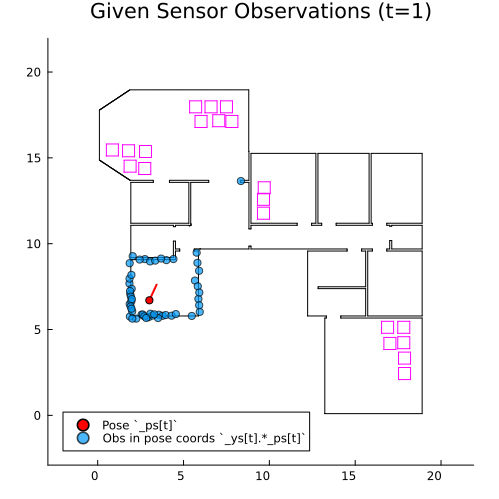

In [10]:
# -----------------------
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = _ys[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Given Sensor Observations (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(shuffle(y[1:2:end]).*p, c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=4)

In [12]:
include("../../src/grid_proposals.jl")

function eval_pose_vectors2(
    vs   :: Array{Vector{Float64}},
    z    :: Vector{Float64},
    segs :: Vector{Segment},
    fov, num_a, w::Int,
    sig, outlier,
    zmax::Float64=50.0; sorted=false)

    # Compute sensor measurements and
    # Gaussian mixture components
    # p_  = CuArray(Vector(p))
    # ps_ = reshape(p_, 1, 3)

    ps   = stack(vs[:])
    segs = stack(Vector.(segs))
    as   = create_angles(fov, num_a)

    if _cuda[]
        ps   = CuArray(ps)
        z    = CuArray(z)
        segs = CuArray(segs)
        as   = CuArray(as)
        sig   = CuArray(sig)
        outlier   = CuArray(outlier)
    end

    z = clamp.(z, 0.0, zmax)

    zs = cast(ps, segs; fov=fov, num_a=num_a, zmax=zmax)
    ỹ, d̃ = get_1d_mixture_components(zs, as, w);

    # Evaluate the the observations with respect to the
    # different Gaussian mixtures computed above
    log_ps,_,outl = depthdist_logpdf(z, ỹ, d̃, sig, outlier, zmax;
                        scale_noise=false, return_pointwise=false, return_outliermap=true);

    # Move everyting back to CPU if is not already there
    log_ps = Array(log_ps)

    # Sort by log prob
    # and return
    # if sorted
    # perm   = sortperm(log_ps)
    # log_ps = log_ps[perm]
    # vs     = vs[:][perm]
    # end

    return log_ps, outl
end;

(10, 10, 10)
  0.012709 seconds (2.72 k allocations: 1.018 MiB)
(1000, 10, 10)(1000, 100, 10, 10)
CartesianIndex(567, 1, 7)
maximum log prob: -85.95651831180501


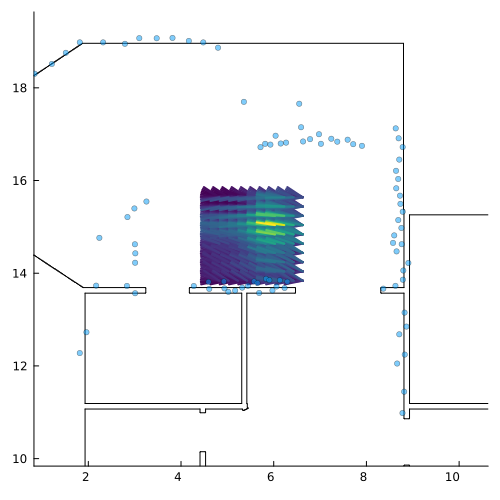

In [21]:
t = 15
z = _zs[t]
p0 = _ps[t] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))

v0 = Vector(p0)
grid_args = (
    k = [10, 10, 10],
    r = [.2, .2, 5/180*π],
)


vs, = vector_grid(v0, grid_args...)

println(size(vs))


w       = 10
sig     = range(0.1, 1., 10)
outlier = range(0.01, 0.4, 10)
zmax    = 25.

@time log_ps, outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

println(size(log_ps), size(outl))
i = argmax(log_ps)
println(i)
x = polar_inv(z, _as)

println("maximum log prob: ", maximum(log_ps))
vals = log_ps[:,i[2],i[3]]
perm = sortperm(vals)
vals = vals[perm]

# -----------------------------
delta = 4
mypl = plot(size=(500,500), legend=nothing, aspect_ratio=:equal,  grid=false, showaxis = true,
    xlim=(vs[1][1]-delta, vs[end][1]+delta),
    ylim=(vs[1][2]-delta, vs[end][2]+delta) 
)
plot!(_segs, c=:black)
cs = cgrad(:viridis)[peak_to_peak(vals)]
plot!(Pose.(vs[perm]), cs, r=.4, linewidth=2)
scatter!(x .* Pose(vs[i[1]]), markerstrokewidth=0.5, c=col[1], alpha=0.5, markersize=3)
display(mypl)


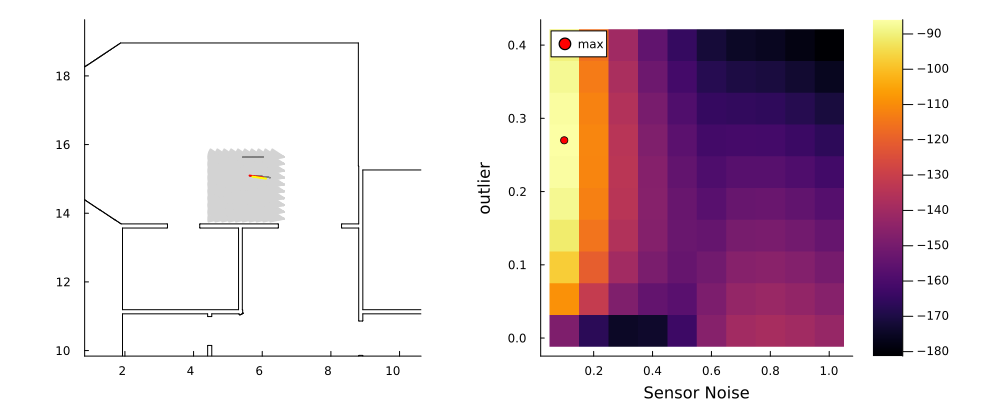

In [22]:
m = dropdims(maximum(log_ps, dims=1), dims=1)
I = dropdims(argmax(log_ps, dims=1), dims=1)
imax = argmax(log_ps)

# -----------------------------
plot_1 = plot(size=(600,400), title="",
    grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
)
heatmap!(sig, outlier, m')
scatter!([sig[imax[2]]],outlier[[imax[3]]], label="max", c=:red)

# -----------------------------
plot_2 = plot(size=(500,500), legend=nothing, aspect_ratio=:equal,  grid=false, showaxis = true,
xlim=(vs[1][1]-delta, vs[end][1]+delta),
ylim=(vs[1][2]-delta, vs[end][2]+delta) 
)
plot!(_segs, c=:black)

plot!(Pose.(vs[:]), c=:lightgray, r=.4, linewidth=2)
for i in I
    plot!(Pose(vs[i[1]]), r=.4, c=:gray, linewidth=1)
end
plot!(Pose(vs[imax[1]]), r=.4, c=:red, linewidth=2)
plot!(_ps[t], r=.4, c=:yellow, linewidth=2)

# -----------------------------
plot(plot_2, plot_1, layout=(1,2), size=(1000,400), margin=3Plots.mm)


  0.029822 seconds (2.95 k allocations: 2.234 MiB)
  0.029815 seconds (3.05 k allocations: 2.242 MiB)
  0.029782 seconds (3.05 k allocations: 2.242 MiB)
  0.029715 seconds (3.05 k allocations: 2.242 MiB)
  0.052686 seconds (3.40 k allocations: 2.255 MiB, 38.40% gc time)
  0.029878 seconds (3.05 k allocations: 2.242 MiB)
  0.050951 seconds (3.33 k allocations: 2.251 MiB, 36.91% gc time)
  0.029920 seconds (3.05 k allocations: 2.243 MiB)
  0.029873 seconds (3.05 k allocations: 2.242 MiB)
  0.045696 seconds (3.42 k allocations: 2.255 MiB, 29.08% gc time)
  0.029795 seconds (3.05 k allocations: 2.243 MiB)
  0.044392 seconds (3.37 k allocations: 2.253 MiB, 27.04% gc time)
  0.029911 seconds (3.05 k allocations: 2.242 MiB)
  0.029785 seconds (3.05 k allocations: 2.242 MiB)
  0.046737 seconds (3.37 k allocations: 2.252 MiB, 29.59% gc time)
  0.029810 seconds (3.05 k allocations: 2.242 MiB)
  0.043855 seconds (3.39 k allocations: 2.254 MiB, 26.48% gc time)
  0.029830 seconds (3.05 k allocation

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/hierarchical_sensor.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/hierarchical_sensor.gif")
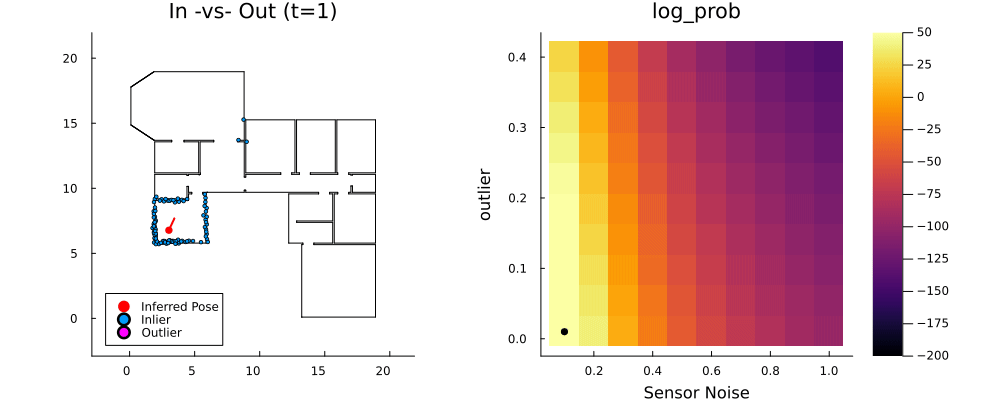

In [33]:

q = _ps[1] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))
qs = []
ani = Animation()
for t=1:30

    z = _zs[t]
    y = _ys[t]

    v0 = Vector(q)
    grid_args = (
        k = [9, 9, 31],
        r = [.2, .2, 1/180*π],
    )

    vs, = vector_grid(v0, grid_args...)

    w       = 10
    sig     = range(0.1, 1., 10)
    outlier = range(0.01, 0.4, 10)
    zmax    = 25.

    @time log_ps,outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

    log_ps = Array(log_ps)
    outl = Array(outl)

    q = Pose(vs[argmax(log_ps)[1]])
    push!(qs, q)
    
    m = dropdims(maximum(log_ps, dims=1), dims=1)
    I = dropdims(argmax(log_ps, dims=1), dims=1)
    imax = argmax(log_ps)

    # -----------------------------
    agent_plot = plot(
        size=(500,500), aspect_ratio=:equal, title="In -vs- Out (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)
    plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=col[1], markersize=2, alpha=1., markerstrokewidth=1, label="Inlier")
    scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=1., markerstrokewidth=1, label="Outlier")
    # -----------------------------
    heat_plot = plot(size=(600,400), title="log_prob",
        grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
    )
    heatmap!(sig, outlier, m', clim=(-200,50))
    scatter!([sig[imax[2]]],outlier[[imax[3]]], label=nothing, c=:black)
    # -----------------------------
    frame(ani, plot(agent_plot, heat_plot, layout=(1,2), size=(1000,400), margin=3Plots.mm))


    q = q + _us[t] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 7/180*π))
end
gif(ani, "_imgs/hierarchical_sensor.gif", fps=5)
# gif(ani, fps=5)

# Version 2

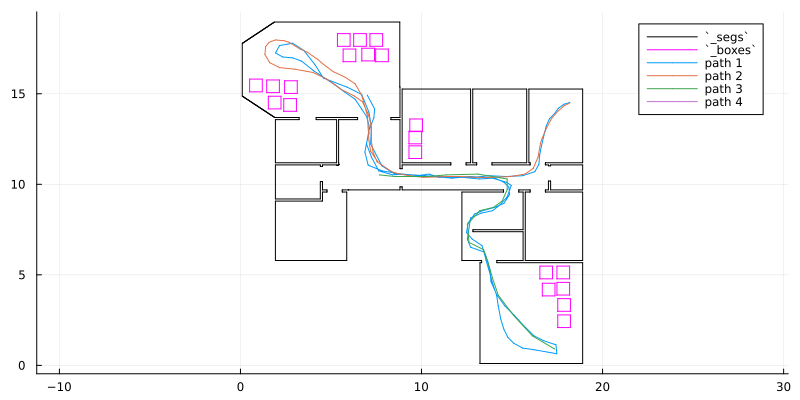

In [36]:
fname = "../data/task_inputs/test_env_3.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=0, c=col[i], label="path $i")
end
mypl

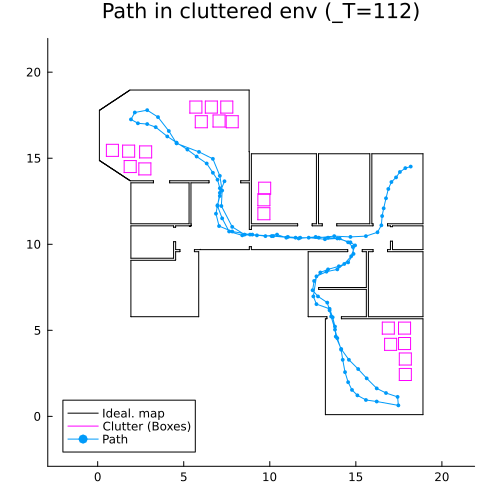

In [37]:
_ps, _us = unpack_path(_paths[1])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

In [51]:
#nbx
_obs_noise = 0.2
_fov       = 2π
_num_a     = 200

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

([[0.7423660765242514, 0.6081557097266257, 0.6271625188334096, 1.0128096748004212, 0.6781439099047104, 0.75713670553779, 0.7796338759005187, 0.8695999832638716, 1.0433848280054394, 0.9985612670040634  …  0.8754805670050507, 1.0996596517635577, 0.8321295330466735, 0.6588751945446367, 0.7140492407652358, 0.6333244454496488, 0.4878303431492424, 0.4570315804549489, 0.588267211353946, 1.0367393940422656], [1.1691085573986202, 1.3252920377785735, 1.3314922471845139, 1.1164308450633715, 1.382346078550717, 1.4496965572493663, 1.1431607044063188, 0.8493968214166262, 0.8342791668593601, 0.8940376741016288  …  1.0914303125120794, 1.497991051207228, 1.159169010605726, 1.117695292984247, 0.9564286407693583, 0.6410483557138554, 1.2407670538560271, 1.66461111331123, 1.377374870326569, 1.3686209727667513], [1.5075851306497778, 1.1760455678160904, 0.7618811578768189, 1.1296208788365685, 1.0770226695745337, 1.3768200910899495, 1.456749078063861, 1.5334043859175919, 1.109376640370825, 0.810759258844701  

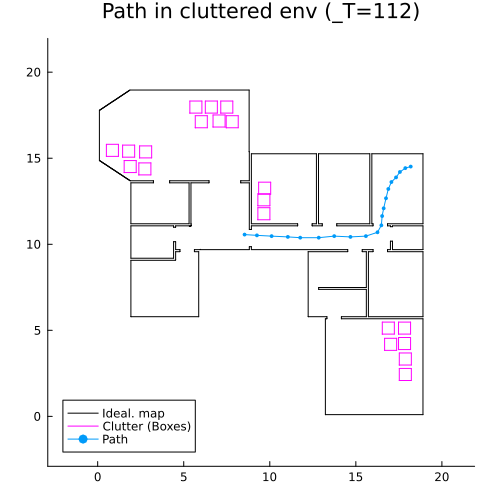

In [52]:
ts1 = 1:20

_ps, _us = unpack_path(_paths[1])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps[ts1]), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

  0.004322 seconds (2.72 k allocations: 317.516 KiB)
  0.004317 seconds (2.82 k allocations: 326.258 KiB)
  0.004397 seconds (2.81 k allocations: 326.211 KiB)
  0.004332 seconds (2.81 k allocations: 326.211 KiB)
  0.004295 seconds (2.81 k allocations: 326.211 KiB)
  0.004295 seconds (2.81 k allocations: 326.211 KiB)
  0.004303 seconds (2.82 k allocations: 326.258 KiB)
  0.004310 seconds (2.81 k allocations: 326.211 KiB)
  0.004360 seconds (2.81 k allocations: 326.211 KiB)
  0.004583 seconds (2.81 k allocations: 326.211 KiB)
  0.004294 seconds (2.81 k allocations: 326.211 KiB)
  0.004416 seconds (2.81 k allocations: 326.508 KiB)
  0.004513 seconds (2.82 k allocations: 326.258 KiB)
  0.004314 seconds (2.81 k allocations: 326.211 KiB)
  0.004357 seconds (2.82 k allocations: 326.258 KiB)
  0.004321 seconds (2.81 k allocations: 326.211 KiB)
  0.004348 seconds (2.81 k allocations: 326.211 KiB)
  0.004356 seconds (2.81 k allocations: 326.211 KiB)
  0.004330 seconds (2.81 k allocations: 326.21

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/kidnap_1.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/kidnap_1.gif")
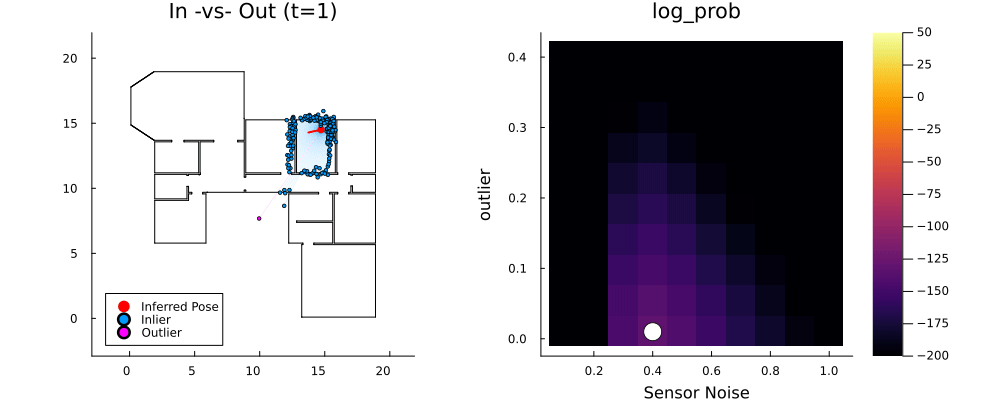

In [64]:

q = _ps[1] + Control([-4;0], 0) + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))
qs = []
ani = Animation()
for t=1:20

    z = _zs[t]
    y = _ys[t]

    v0 = Vector(q)

    grid_args = (
        k = [5, 5, 5],
        r = [.2, .2, 2/180*π],
    )

    vs, = vector_grid(v0, grid_args...)

    w       = 10
    sig     = range(0.1, 1., 10)
    outlier = range(0.01, 0.4, 10)
    zmax    = 25.

    @time log_ps,outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

    log_ps = Array(log_ps)
    outl = Array(outl)

    q = Pose(vs[argmax(log_ps)[1]])
    push!(qs, q)
    
    m = dropdims(maximum(log_ps, dims=1), dims=1)
    I = dropdims(argmax(log_ps, dims=1), dims=1)
    imax = argmax(log_ps)

    # -----------------------------
    agent_plot = plot(
        size=(500,500), aspect_ratio=:equal, title="In -vs- Out (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    # for j=1:5:length(y)
    for yy in y[.!outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=col[1], alpha=0.1, label=nothing)
    end
    for yy in y[outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=:magenta, alpha=0.1, label=nothing)
    end

    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)
    plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    
    scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=col[1], markersize=2, alpha=1., markerstrokewidth=1, label="Inlier")
    scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=1., markerstrokewidth=1, label="Outlier")

    # -----------------------------
    heat_plot = plot(size=(600,400), title="log_prob",
        grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
    )
    heatmap!(sig, outlier, m', clim=(-200,50))
    scatter!([sig[imax[2]]],outlier[[imax[3]]], label=nothing, markersize=10, c=:white)
    # -----------------------------
    frame(ani, plot(agent_plot, heat_plot, layout=(1,2), size=(1000,400), margin=3Plots.mm))


    q = q + _us[t] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 7/180*π))
end
gif(ani, "_imgs/kidnap_1.gif", fps=2)
# gif(ani, fps=5)

# Version 3

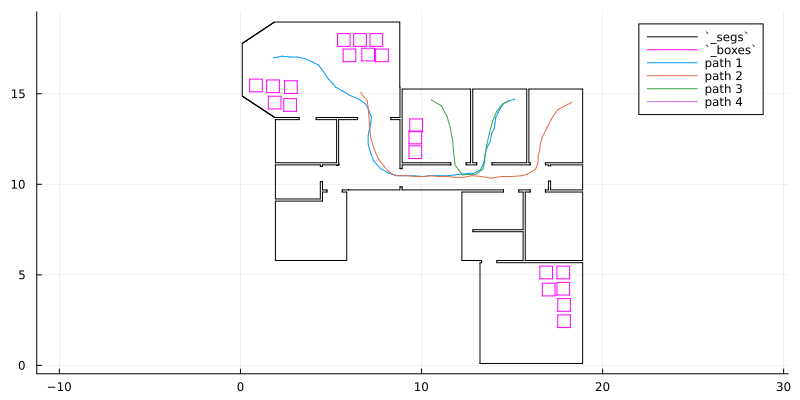

In [67]:
fname = "../data/task_inputs/test_env_4.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=0, c=col[i], label="path $i")
end
mypl

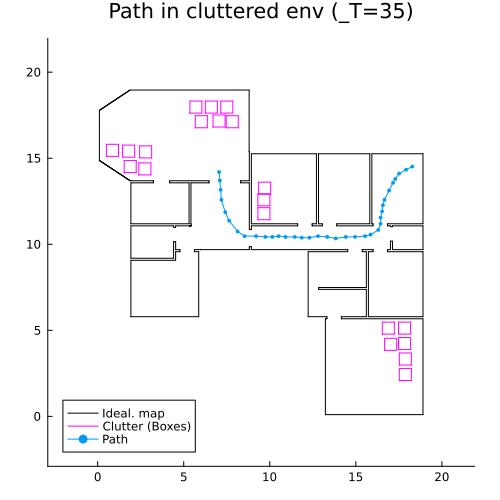

In [72]:
_ps, _us = unpack_path(_paths[2])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

In [75]:
#nbx
_obs_noise = 0.1
_fov       = 2π
_num_a     = 100

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

([[0.7955959440617163, 0.8362007292678642, 0.7924008244213072, 0.9781765777747735, 0.7166544873718134, 0.8689735159826761, 0.9884919328295327, 0.7775560885545615, 0.8575629905980932, 0.923970882533581  …  0.7502335240119683, 0.7573071822615597, 0.7289751652595705, 0.44290321523690757, 0.6448834277161916, 0.5947739599776187, 0.6958289056495012, 0.7220676016467369, 0.5855950679611168, 0.6625321015789302], [1.1568510365442026, 1.2763746275342196, 1.356190256420066, 1.2920856976721213, 1.4847199050539643, 1.3419160161747035, 1.1987273940552226, 1.0833807350499856, 1.092820268935238, 1.017378909599453  …  0.8744855713592055, 0.983883420573583, 1.1133420652318213, 1.005808879264588, 0.7963228520118241, 0.9584515931498065, 1.0523729978276068, 0.8356663252420197, 1.0962156797596359, 1.2249478306667536], [1.4867291624645003, 1.310976772219323, 1.3162169655425655, 1.3435155866186865, 1.2604061288207795, 1.1939532185747272, 1.2398731914646777, 1.0921979210441646, 1.2180125563604975, 1.11099366633

  0.749485 seconds (3.72 k allocations: 10.784 MiB, 79.79% gc time)
  0.721092 seconds (3.81 k allocations: 10.792 MiB, 79.90% gc time)
  0.706297 seconds (3.82 k allocations: 10.793 MiB, 79.22% gc time)
  0.715557 seconds (3.82 k allocations: 10.793 MiB, 79.87% gc time)
  0.713048 seconds (3.82 k allocations: 10.793 MiB, 79.87% gc time)
  0.731732 seconds (3.82 k allocations: 10.793 MiB, 79.93% gc time)
  0.732705 seconds (3.81 k allocations: 10.792 MiB, 79.98% gc time)
  0.730368 seconds (3.81 k allocations: 10.792 MiB, 80.26% gc time)
  0.752086 seconds (3.82 k allocations: 10.793 MiB, 80.83% gc time)
  0.719348 seconds (3.82 k allocations: 10.793 MiB, 79.67% gc time)
  0.720767 seconds (3.82 k allocations: 10.793 MiB, 79.95% gc time)
  0.781397 seconds (3.82 k allocations: 10.793 MiB, 80.98% gc time)
  0.709815 seconds (3.81 k allocations: 10.792 MiB, 79.83% gc time)
  0.716146 seconds (3.81 k allocations: 10.792 MiB, 79.47% gc time)
  0.731158 seconds (3.82 k allocations: 10.793 M

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/kidnap_wrong_room_2.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/kidnap_wrong_room_2.gif")
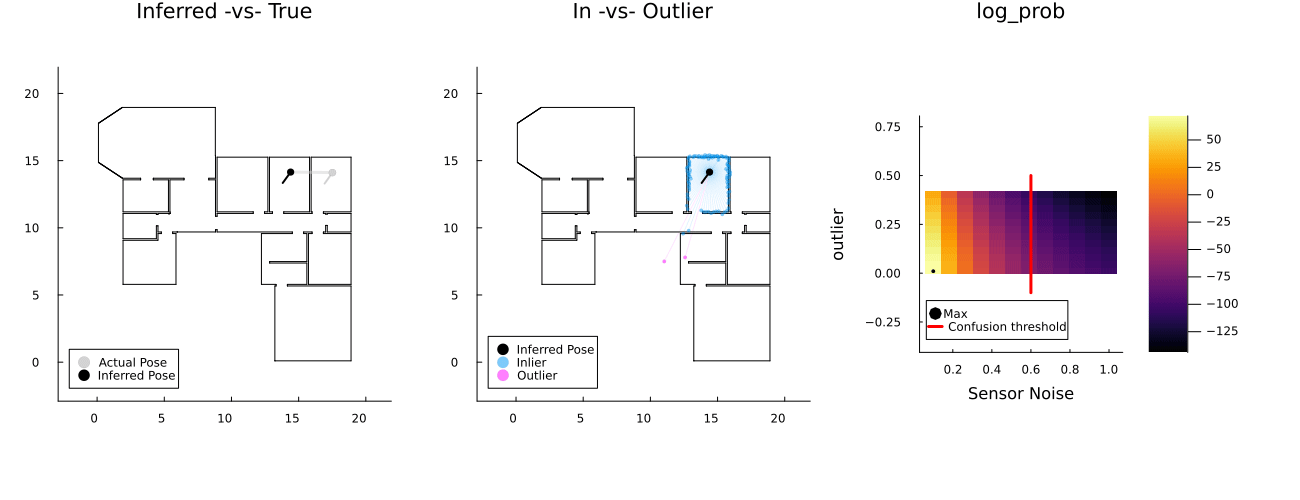

In [183]:

q = _ps[1] + Control([-4;0], 0) + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))
qs = []
ani = Animation()

grid_args = (
    k = [21, 21, 21],
    r = [.1, .1, 2/180*π],
)

confused = false

t=1
# while t < 6
while t < _T
# for t=1:_T

    z = _zs[t]
    y = _ys[t]

    v0 = Vector(q)

    # grid_args = (
    #     k = [11, 11, 11],
    #     r = [.1, .1, 2/180*π],
    # )

    vs, = vector_grid(v0, grid_args...)

    w       = 10
    sig     = range(0.1, 1., 12)
    outlier = range(0.01, 0.4, 12)
    zmax    = 25.

    @time log_ps,outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

    log_ps = Array(log_ps)
    outl = Array(outl)

    q = Pose(vs[argmax(log_ps)[1]])
    push!(qs, q)
    
    m = dropdims(maximum(log_ps, dims=1), dims=1)
    I = dropdims(argmax(log_ps, dims=1), dims=1)
    imax = argmax(log_ps)

    if sig[imax[2]] < 0.6 
        confused = false
    else 
        confused = true
    end

    # -----------------------------
    agent_plot1 = plot(
        size=(500,500), aspect_ratio=:equal, title="In -vs- Outlier", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )

    for yy in y[.!outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=col[1], alpha=0.1, label=nothing)
    end
    for yy in y[outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=:magenta, alpha=0.1, label=nothing)
    end

    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)

    # plot!([q.x,_ps[t].x], c=:lightgray, alpha=.5, linewidth=3, label=nothing)
    # plot!([_ps[t]], c=:lightgray, r=1.0, linewidth=2, label=nothing)
    # scatter!([_ps[t].x], c=:lightgray,  markerstrokewidth=0, label="Actual Pose")
    if confused
        plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    else
        plot!([q], c=:black, r=1.0, linewidth=2, label=nothing)
        scatter!([q.x], c=:black,  markerstrokewidth=0, label="Inferred Pose")
    end
    
    scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=col[1], markersize=2, alpha=.5, markerstrokewidth=0, label="Inlier")
    scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=.5, markerstrokewidth=0, label="Outlier")



    s =(sig[imax[2]] - sig[1])/sig[end] 
    c = RGBA(1,0,0, s)
    # c = cgrad(:berlin)[s] 
    annotate!(10,20, text("NOSIE!", 12, c, :left))

    # s = (outlier[imax[3]] - outlier[1])/outlier[end]
    # c = cgrad(:berlin)[s] 
    # c = RGBA(1,0,0, s)
    # annotate!(16,20, text("OUTLIERS!", 12, c, :left))
    # -----------------------------
    agent_plot2 = plot(
        size=(500,500), aspect_ratio=:equal, title="Inferred -vs- True", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    # for j=1:5:length(y)
    # for yy in y[.!outl[imax[1],:,imax[2],imax[3]]]
    #     plot!([zeros(2), yy].*q, c=col[1], alpha=0.1, label=nothing)
    # end
    # for yy in y[outl[imax[1],:,imax[2],imax[3]]]
    #     plot!([zeros(2), yy].*q, c=:magenta, alpha=0.1, label=nothing)
    # end

    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)

    plot!([q.x,_ps[t].x], c=:lightgray, alpha=.5, linewidth=3, label=nothing)
    plot!([_ps[t]], c=:lightgray, r=1.0, linewidth=2, label=nothing)
    scatter!([_ps[t].x], c=:lightgray,  markerstrokewidth=0, label="Actual Pose")
    if confused
        plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    else
        plot!([q], c=:black, r=1.0, linewidth=2, label=nothing)
        scatter!([q.x], c=:black,  markerstrokewidth=0, label="Inferred Pose")
    end
    
    # scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=:black, markersize=2, alpha=.5, markerstrokewidth=0, label="Inlier")
    # scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=.5, markerstrokewidth=0, label="Outlier")



    s =(sig[imax[2]] - sig[1])/sig[end] 
    c = RGBA(1,0,0, s)
    # c = cgrad(:berlin)[s] 
    annotate!(10,20, text("NOISE!", 12, c, :left))



    # s = (outlier[imax[3]] - outlier[1])/outlier[end]
    # c = cgrad(:berlin)[s] 
    # c = RGBA(1,0,0, s)
    # annotate!(16,20, text("OUTLIERS!", 12, c, :left))


    # -----------------------------
    heat_plot = plot(size=(400,400), title="log_prob", aspect_ratio=:equal, legend_position=:bottomleft, legend_font_size=6,
        grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm, bottom_margin = 10Plots.mm,
    )
    heatmap!(sig, outlier, m') #clim=(-200,50))
    scatter!([sig[imax[2]]],[outlier[imax[3]]], label="Max", markersize=2, marker=:o, c=:black)
    plot!([[0.6,-0.1],[0.6,0.5]], c=:red, linewidth=3, label=" Confusion threshold"   )
    # -----------------------------

    if t > 2
        frame(ani, plot(agent_plot2,agent_plot1, heat_plot, layout=(1,3), size=(1300,500), margin=5Plots.mm))
    end


    if !confused
        t+=1
        grid_args = (
            k = [21, 21, 21],
            r = [.1, .1, 2/180*π],
        )
        u = _us[t-1]
    else 
        grid_args = (
            k = [21, 21, 21],
            r = [.3, .3, 2/180*π],
        )
        u = Control([0;0], 0)
    end

    q = q + u + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 5/180*π))
end
gif(ani, "_imgs/kidnap_wrong_room_2.gif", fps=4)
# gif(ani, fps=5)

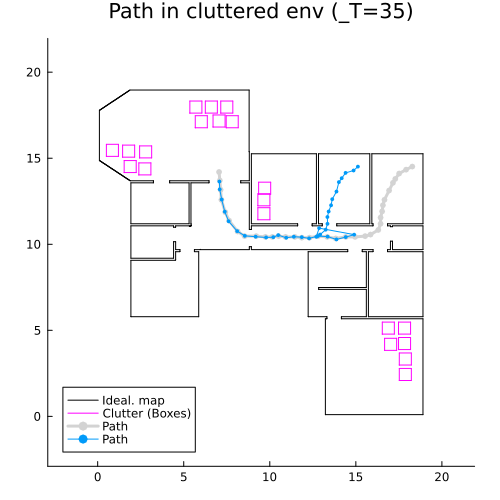

In [184]:
# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=:lightgray, marker=:o, markersize=3, markerstrokewidth=0, linewidth=3, label="Path")
plot!(Pose2D.position.(qs), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl